In [3]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.io import arff
import xgboost as xgb
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics

## Wczytanie danych

In [2]:
df = pd.read_csv("students-all.csv")
# remove rownames
df = df.iloc[:,1:]

In [3]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0


## Funkcja ternująca na xgboost

In [4]:
def train_fast(df, max_depth, target ):
    
    """
    From Standard cross validation differs in data partitnion. Due to optimizing model on validation set,
    we get final AUC score from equally big test set.
    """
    
    # shuffling index
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    
    # 5 fold cross validation
    kf = KFold(n_splits=5)
        
    
    ret = []
    tpr_arr = []
    fpr_arr = []
    
    # we will make test 10% and validation 10%
    for train_index, test_index in kf.split(df):
        
        train = df.iloc[train_index,:]
        
        v_ind = test_index[0:(len(test_index)//2)] 
        t_ind = test_index[(len(test_index)//2):len(test_index)]
        
        validation = df.iloc[v_ind,:]
        test = df.iloc[t_ind,:]
        
        label_train = train[target]
        label_val = validation[target]
        label_test = test[target]

        df_train = train.drop([target], axis = 1)
        df_test  = test.drop([target], axis = 1)
        df_val  = validation.drop([target], axis = 1)
        
        dtrain = xgb.DMatrix(data = df_train, label=label_train)
        dval = xgb.DMatrix(data = df_val, label=label_val)
        dtest = xgb.DMatrix(data = df_test, label=label_val)
        
        param = {'max_depth': max_depth, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        evallist = [(dval, 'eval'), (dtrain, 'train')]
        
        num_round = 100
        
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
        y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

        fpr, tpr, thresholds = metrics.roc_curve(label_test.to_numpy(), y_pred)

        
        ret.append(metrics.auc(fpr, tpr))
        
        fpr_arr.append(fpr)
        tpr_arr.append(tpr)
        
    # fpr and tpr arrays are problematic, we will get them from median AUC score
    # note that we are returning mean auc score, so it is not ideal 
    index = np.where(np.mean(np.array(ret))== np.mean(np.array(ret)))[0][0]
    
    
    return np.array(ret).mean(), bst, fpr_arr[index],tpr_arr[index]

In [5]:
auc, _, _,_ = train_fast(df_dummies, 13, "romantic_yes")
auc

0.83010280915168

## Uśrednione auc

In [6]:
def get_auc_mean(df, max_depth, target = "romantic_yes", n = 10):
    auc_sum = 0
    for i in range(n):
        auc, bst, _, _ = train_fast(df, max_depth, target)
        auc_sum += auc
    return auc_sum/n

Zobaczmy jak zachowuje się xgboost przy różnych parametrach max_depth. Może chwilę potrwać

In [7]:
%%capture
auc_results = []

for i in range(40): 
    auc = get_auc_mean(df_dummies, i, "romantic_yes")
    auc_results.append(auc)

In [8]:
# Zróbmy średnią kroczącą 
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
a = moving_average(np.array(auc_results),5)

Text(0.5, 1.0, 'auc based on max_depth')

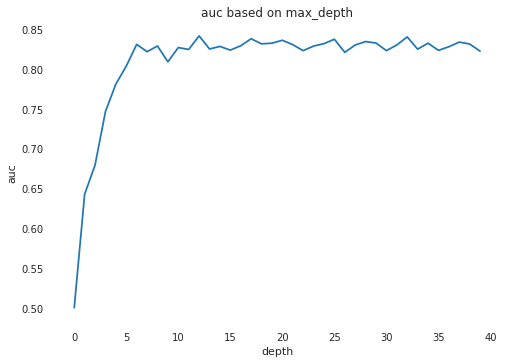

In [10]:
res = pd.DataFrame({"auc": auc_results, "depth": [i for i in range(40)]})
sns.lineplot(data = res, x = "depth", y = "auc").set_title("auc based on max_depth")

Text(0.5, 1.0, 'moving average of auc, base = 5')

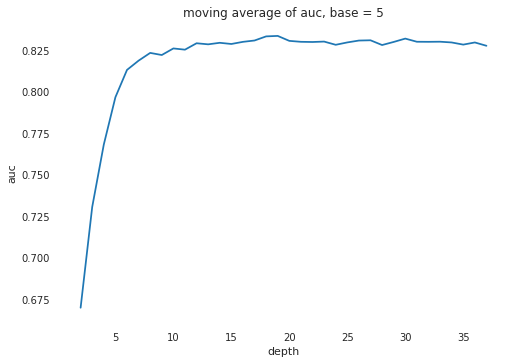

In [11]:
res = pd.DataFrame({"auc":a,"depth":np.arange(len(auc_results))[2:-2]})
sns.lineplot(data = res, x = "depth", y = "auc").set_title("moving average of auc, base = 5")

## Różne encodery

In [12]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'major'],
      dtype='object')

In [13]:
df['romantic'] = np.where(df['romantic']=='yes', 1, 0)
y = df[['romantic']].copy()
df = df.drop(columns='romantic')

In [14]:
import category_encoders as ce

encolums = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'major']

In [15]:
%%capture
res_dict = {}
encoder = ce.backward_difference.BackwardDifferenceEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BackwardDifferenceEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [16]:
%%capture
encoder = ce.binary.BinaryEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BinaryEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [17]:
%%capture
encoder = ce.basen.BaseNEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BaseNEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [18]:
%%capture
encoder = ce.hashing.HashingEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["HashingEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [19]:
%%capture
encoder = ce.helmert.HelmertEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["HelmertEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [20]:
%%capture
encoder = ce.one_hot.OneHotEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [21]:
%%capture
encoder = ce.ordinal.OrdinalEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [22]:
%%capture
encoder = ce.polynomial.PolynomialEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [23]:
%%capture
encoder = ce.sum_coding.SumEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

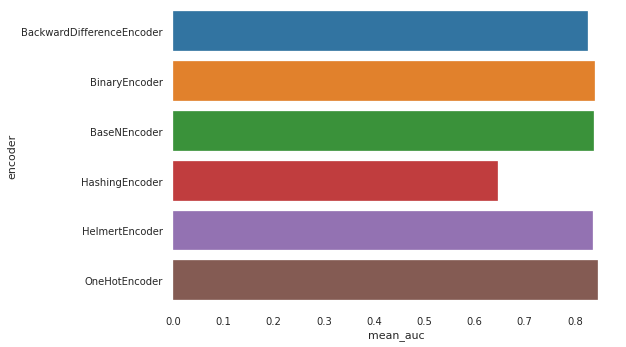

In [24]:
res_df = pd.DataFrame({"encoder": list(res_dict.keys()), "mean_auc": list(res_dict.values())})
sns.barplot(data = res_df, y = "encoder", x = "mean_auc")

In [25]:
from pprint import pprint
pprint(res_df)

                     encoder  mean_auc
0  BackwardDifferenceEncoder  0.826205
1              BinaryEncoder  0.840831
2               BaseNEncoder  0.837968
3             HashingEncoder  0.646296
4             HelmertEncoder  0.835151
5              OneHotEncoder  0.846921


Najlepiej radzi sobie one_hot_encoder, w kolejnych obliczeniach używać będziemy jego najbliżeszego kuzyna `dummies`

## Logarytmowanie zmiennych ciągłych

Widzimy, że najlepiej wypada model dla głębokości około 40, ale ogólnie charakteryzuje się sporą wariancją wyniku accuracy

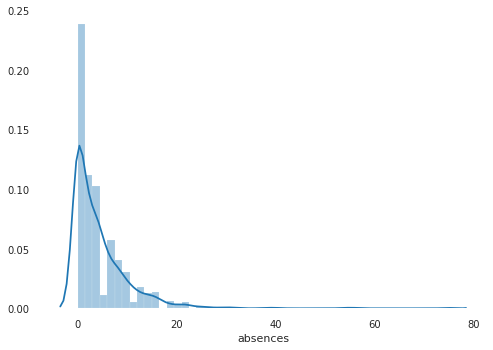

In [26]:
sns.distplot(df_dummies.absences)

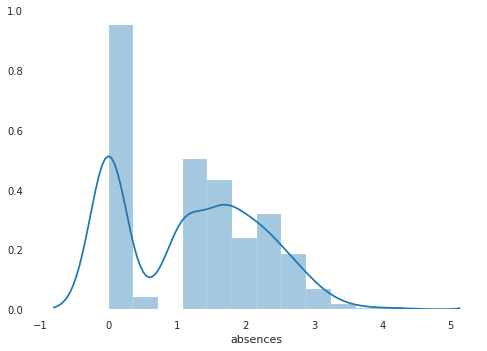

In [27]:
sns.distplot(np.log(df_dummies.absences+1)) 

In [28]:
df_dummies["absences"] = np.log(df.absences +1)

In [31]:
get_auc_mean(df_dummies, 19)

0.8308870015508489

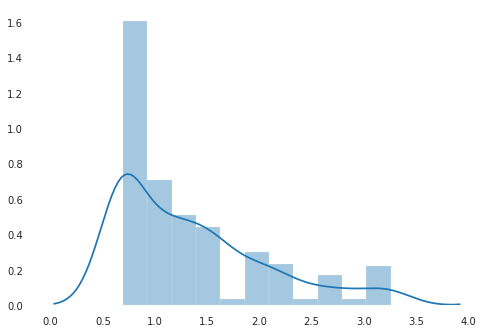

In [38]:
sns.distplot(np.log(df_dummies.loc[df_dummies.romantic_yes == 1].Walc * df_dummies.loc[df_dummies.romantic_yes == 1].Dalc + 1))

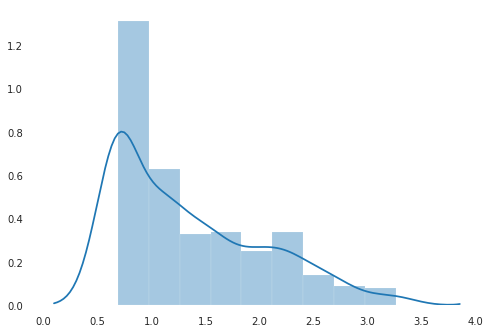

In [39]:
sns.distplot(np.log(df_dummies.loc[df_dummies.romantic_yes == 0].Walc * df_dummies.loc[df_dummies.romantic_yes == 0].Dalc +1))

In [43]:
df_dummies["WeekandEnd"] = np.log(df_dummies.Walc * df_dummies.Dalc +1)

In [44]:
get_auc_mean(df_dummies, 19)  # idziemy do przodu

0.8373756581558108

In [45]:
a = np.where((df_dummies.Dalc > 3)&(df_dummies.Walc <3),1,0 )   # wniosek z eda, osoby oznaczone w tej kolumnie jako 1, to wyłącznie romantycy
df_dummies["WeirdDrinker"] = a

In [48]:
get_auc_mean(df_dummies,19)      # porównywalnie z ostatnią

0.8369038503612398

## PCA

In [53]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [56]:
pca = PCA(n_components=10) 
X = preprocessing.normalize(df_dummies.drop("romantic_yes", axis = 1), norm='l2')

principalComponents = pca.fit_transform(X)

cols = []
for i in range(10): 
    cols.append("pc"+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,0.291357,-0.002311,-0.068393,-0.104923,0.132938,-0.017749,-0.000915,-0.005140,0.019595,0.029207
1,0.293148,-0.014609,-0.150128,-0.030613,0.003739,-0.047496,0.017811,0.000414,0.035211,-0.036633
2,0.065921,-0.117236,-0.074606,0.000284,-0.021249,0.022799,0.022122,-0.010901,-0.017853,-0.055132
3,-0.190891,0.069406,0.031124,-0.042399,-0.026171,0.030748,0.026886,-0.022249,0.008715,0.018455
4,0.058324,-0.061050,-0.065479,-0.137130,0.010410,0.032568,-0.062080,-0.007562,0.000079,-0.006048
...,...,...,...,...,...,...,...,...,...,...
1039,0.076266,0.019750,-0.048860,-0.049731,-0.027927,0.011546,-0.026540,-0.009539,-0.017109,-0.026529
1040,-0.157430,0.026529,-0.045725,0.067675,0.041065,-0.023281,0.014691,-0.011653,0.005087,0.007439
1041,0.012407,0.073764,-0.076955,0.019305,-0.081743,0.139695,-0.014790,-0.072080,-0.014536,0.044395
1042,0.055787,-0.105887,0.039204,0.093804,0.034678,0.005027,0.009558,-0.022210,-0.032627,0.034122


In [58]:
pca.explained_variance_ratio_.cumsum()   # 55 % wariancji w 2 ważnych kolumnach

array([0.48064371, 0.55648099, 0.61878967, 0.66826408, 0.71678488,
       0.75103801, 0.78087927, 0.80322884, 0.82247924, 0.84129396])

zredukowaliśmy wymiar do 10

In [59]:
pca_df = pd.concat([principalDf,df_dummies.romantic_yes],axis =1)
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,romantic_yes
0,0.291357,-0.002311,-0.068393,-0.104923,0.132938,-0.017749,-0.000915,-0.005140,0.019595,0.029207,0
1,0.293148,-0.014609,-0.150128,-0.030613,0.003739,-0.047496,0.017811,0.000414,0.035211,-0.036633,0
2,0.065921,-0.117236,-0.074606,0.000284,-0.021249,0.022799,0.022122,-0.010901,-0.017853,-0.055132,0
3,-0.190891,0.069406,0.031124,-0.042399,-0.026171,0.030748,0.026886,-0.022249,0.008715,0.018455,1
4,0.058324,-0.061050,-0.065479,-0.137130,0.010410,0.032568,-0.062080,-0.007562,0.000079,-0.006048,0
...,...,...,...,...,...,...,...,...,...,...,...
1039,0.076266,0.019750,-0.048860,-0.049731,-0.027927,0.011546,-0.026540,-0.009539,-0.017109,-0.026529,0
1040,-0.157430,0.026529,-0.045725,0.067675,0.041065,-0.023281,0.014691,-0.011653,0.005087,0.007439,0
1041,0.012407,0.073764,-0.076955,0.019305,-0.081743,0.139695,-0.014790,-0.072080,-0.014536,0.044395,0
1042,0.055787,-0.105887,0.039204,0.093804,0.034678,0.005027,0.009558,-0.022210,-0.032627,0.034122,0


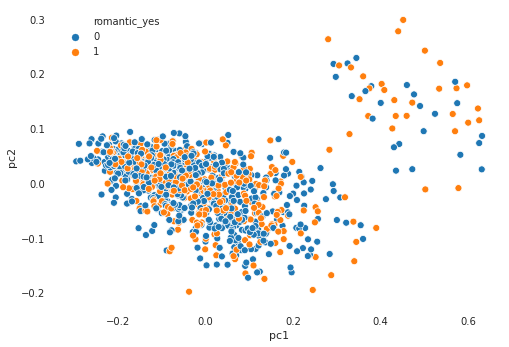

In [60]:
sns.scatterplot(x = "pc1", y = "pc2", data = pca_df, hue = "romantic_yes")  

Nie widać widocznego podziału danych

In [62]:
get_auc_mean(pca_df, 19)

0.6363860041803175

Czyli najlepsze średnie AUC dostaliśmy po przekształceniach
ramki danych logarytmicznie i eksponując niektóre zależności